# Data Wrangling and Exploratory Data Analysis

- 1. [Introduction](#1.-Introduction)
- 2. [Imports](#2.-Imports)
- 3. [Environments](#3.-Environments)
      - 3.1 CarRacing-v0
      - 3.2 CarRacing-v1
- 4. [Visualizing Filters](#4.-Visualizing-Filters)
- 5. [Visualizing Feature Maps](#5.-Visualizing-Feature-Maps)

# 1. Introduction

In this project, we attempt to build an car racing agent that can successfully and consistently complete a racing track. The agent must learn how to complete the track autonomously, without the aid of any hard-coded business logic. We leverage the [OpenAI Gym CarRacing interface](https://gym.openai.com/envs/CarRacing-v0/) as the environment from which our agent learns. We also experiment with an open-source [car racing environment](https://github.com/NotAnyMike/gym) that has a discrete action space and other useful modifications.

In this notebook, we perform the following steps:
- Because our data is fairly clean, data wrangling is minimal. Instead, we explore ways to make the environment state simpler before it reaches our model as input.
- We explore plausible architectures for our convolutional neural network to detect spatial features of our game. This includes experimenting with filter sizes and observing how they affect what our model ingests.

# 2. Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D
from tensorflow.keras import Model

dataset_v0 = np.load('./car_racing_v0_dataset.npy')
dataset_v1 = np.load('./car_racing_v1_dataset.npy')

# 3. Environments

We experiment with two different environments based on the OpenAI Gym CarRacing environment. By using this ecosystem, we frame the problem as an agent-environment feedback loop that we see in many classic reinforcement learning problems. The agent will observe the environment and an associated reward signal, perform an action based on the given information, and observe the subsequent environment state and reward, and so on and so forth. Training is composed of a series of episodes, where the end of an episode is marked by the completion of the track or forceful termination.

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

- **CarRacing-v0**: The original OpenAI Gym environment
    - Observation Space: $96 \times 96$ RGB pixel array (96, 96, 3)
    - Action Space (continuous): Based on three continuous values representing steer, gas, and brake.
- **CarRacing-v1**: The custom, open-source environment based on v0.
    - Observation Space: 4 $96 \times 96$ pixel grayscale images stacked consecutively (96, 96, 4)
    - Action Space (discrete): Based on 5 actions: left, right, accelerate, nothing, and brake.

In [2]:
def plot_rgb_frame(frame, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    
    ax.imshow(frame / 255.)
    ax.set_xticks([])
    ax.set_yticks([])

def grayscale(rgb):  
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

## 3.1 CarRacing-v0

### 3.1.1 State
To get an idea of the state our agent will observe, we collected 100 frames from an episode using an agent that performed random actions. Here are five consecutive frames from that dataset:

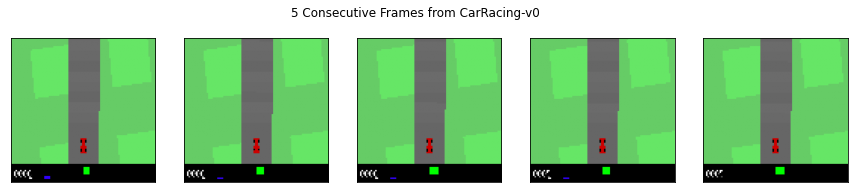

In [3]:
_, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, frame in enumerate(dataset_v0[50:55]):
    plot_rgb_frame(frame, ax=axes[i])
    
plt.suptitle('5 Consecutive Frames from CarRacing-v0');

There are three takeaways from observing these sample frames:
1. The frame includes a black information panel at the bottom of the screen. This contains metrics like true speed, four ABS sensors, steering wheel position, and gyroscope.
2. How do we determine the speed of the vehicle through the state?
3. All five frames are nearly identical.
4. The vehicle and the grassy areas bordering the road are bright, saturated colors. Does a gray-scaled image provide sufficient information for our model to learn?

(1) It's unclear whether we require these metrics to inform our model. If we do not need them, they may hinder learning as we are needlessly adding complexity to our model's input. Cropping it completely would yield a (84, 96, 3) pixel array, like the figure below. 

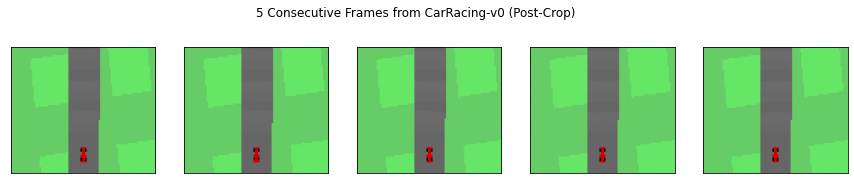

In [4]:
_, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, frame in enumerate(dataset_v0[50:55]):
    frame = frame[:84, :]
    plot_rgb_frame(frame, ax=axes[i])

plt.suptitle('5 Consecutive Frames from CarRacing-v0 (Post-Crop)');

(2) The only way to determine the speed of the vehicle from state is to parse the true speed indicator in the bottom panel. Parsing this accurately and computing true speed as a proportion of a maximum speed is a difficult task. If we try to derive the true speed based on previous actions performed, we would be defying the Markov property and this would no longer be a reinforcement learning problem. 

For a series of Atari games, Mnih et al [1] combatted this issue by using a stack of frames to capture motion in the game's animation. Using this approach, we can consider a single unit of input as a stack of sub-frames of size $\phi$, where the agent chooses an action at every $\phi$ time step. This is a step in the right direction, but we are still faced with the next point.

(3) The consecutive frames are so similar because the default frames per second for this environment is fairly high at 50. As a result, unless $\phi$ is sufficiently large, we will likely have a stack of virtually identical sub-frames, where the vehicle still appears static.

Again, in Mnih et al [1], they also utilized a frame-dropping parameter to reject frames in between each "consecutive" frame. In other words, every sub-frame in our stack is $N$ time steps away from each of its neighbors and as a result, we will likely observe noticeable differences in state as we move further along into our stack.

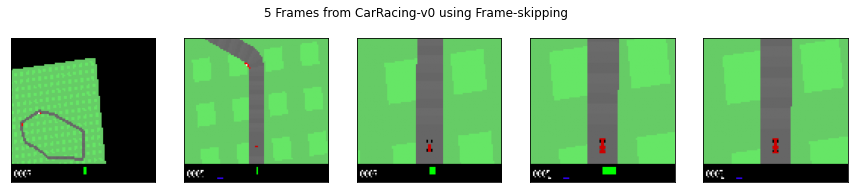

In [5]:
_, axes = plt.subplots(1, 5, figsize=(15, 3))
axes_iter = iter(axes.flatten())
for i in range(0, 100, 20):
    ax = next(axes_iter)
    plot_rgb_frame(dataset_v0[i], ax=ax)
    
plt.suptitle('5 Frames from CarRacing-v0 using Frame-skipping');

In this exaggerated example, we drop 20 frames before collecting the next sub-frame. Here, we can now see the environment progressively zooming into the vehicle along the track.

(3) I assume the most critical features of our state are the shape of the track and the position of the car relative to the track. If the model can already determine these features from a gray-scaled image, then we would not need extra image channels. We plot a gray-scaled version of the image below:

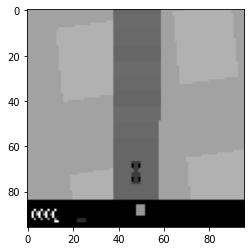

In [6]:
plt.imshow(grayscale(dataset_v0[50]), cmap='gray');

The distinction between the vehicle and the track has definitely reduced by gray-scaling. Only through experimentation can we determine whether this will be sufficient for our model to properly learn.

### 3.1.2 Actions

The actions in CarRacing-v0 are represented by three continuous values: Steering, gas, and brake. Steering is a number in $[-1, 1]$ and gas and brake are numbers in $[0, 1]$. Because of the intractability in deciding between an infinite number of actions, we must discretize this continuous space in some simpler, meaningful way.

### 3.1.3 Rewards

The reward function for this environment is $1000 - \frac{1}{10} N$ where $N$ is the number of frames it takes to complete the track. The [criteria](https://github.com/openai/gym/wiki/Leaderboard) for solving this environment is to achieve over an average reward of 900 over 100 consecutive episodes. 

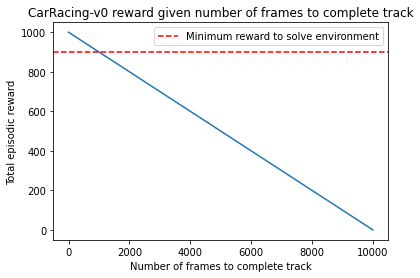

In [7]:
def v0_reward(num_frames):
    return 1000 + (-0.1) * num_frames

X = np.arange(10000)
Y = v0_reward(X)

plt.plot(X, Y)
plt.axhline(y=900, color='r', linestyle='--', label='Minimum reward to solve environment')
plt.ylabel('Total episodic reward')
plt.xlabel('Number of frames to complete track')
plt.title('CarRacing-v0 reward given number of frames to complete track')
plt.legend()
plt.show()

If the agent gets stuck outside of the track with no probable way of reaching the end of the track, we would have to wait until the episode terminates. It may be worth investing in early termination to handle these cases to speed up learning.

## 3.2 CarRacing-v1

### 3.2.1 State
The state we decided was a frame stack of 4 gray-scale frames. We also remove the bottom panel from each frame.

In [8]:
def plot_grayscale_frame_stack(frame, figsize=(10, 3)):
    num_frames = frame.shape[2]
    fig, axes = plt.subplots(1, num_frames, figsize=figsize)
    for i in range(num_frames):
        axes[i].imshow(frame[:, :, i], cmap='gray')
        axes[i].set_xticks([])
        axes[i].set_yticks([])

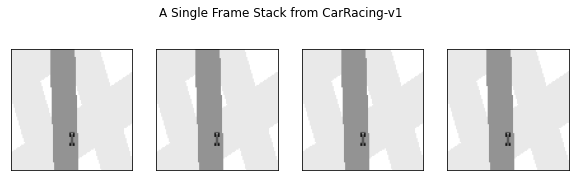

In [9]:
plot_grayscale_frame_stack(dataset_v1[50])
plt.suptitle('A Single Frame Stack from CarRacing-v1');

### 3.2.2 Actions

This environment offers a few options for the action space. We will be trying the following discrete action space for its simplicity:
* TURN_LEFT: $[ -1, 0, 0]$
* TURN_RIGHT: $[ 1, 0, 0]$
* ACCELERATE: $[ 0, 1, 0]$
* BRAKE: $[ 0, 0, 0.8]$
* DO_NOTHING: $[ 0, 0, 0]$

### 3.2.3 Rewards
The reward function is similar to CarRacing-v0 except it incurs a -100 reward when the vehicle is outside of the track for more than 2 seconds.

# 4. Visualizing Filters 
Taking inspiration from [1], we seek to train a deep Q-network to help our agent navigate the race track. A deep Q-network uses a deep convolutional neural network (CNN) as a function approximator for a Q-function, which estimates the value of taking a particular action in a given state. CNNs use filters that convolve on the given image to capture spatial features like edges and shapes while also reducing the image's dimensionality so that learning becomes more tractable.

Determining a model architecture that is suitable for this learning task is not trivial or straightforward. We construct a sample model with no fully connected layers to visualize how filtering and pooling input images affects what our neural network sees.

In [10]:
def initialize_model(input_shape):
    visible = Input(shape=input_shape, name='input')
    conv1   = Conv2D(filters=8, kernel_size=(3, 3), activation='relu', name='conv1')(visible)
    pool1   = MaxPooling2D(pool_size=(2, 2), strides=2, name='pool1')(conv1)
    conv2   = Conv2D(filters=16, kernel_size=(5, 5), activation='relu', name='conv2')(pool1)
    pool2   = MaxPooling2D(pool_size=(2, 2), strides=2, name='pool2')(conv2)
    model   = Model(inputs=visible, outputs=pool2, name='model')
    return model

In [11]:
model = initialize_model(input_shape=dataset_v0[0].shape)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 94, 94, 8)         224       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 47, 47, 8)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 43, 43, 16)        3216      
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 21, 21, 16)        0         
Total params: 3,440
Trainable params: 3,440
Non-trainable params: 0
_________________________________________________________________


2021-09-15 22:50:31.896331: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-09-15 22:50:31.901485: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2994375000 Hz
2021-09-15 22:50:31.903089: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55ef905c1c20 executing computations on platform Host. Devices:
2021-09-15 22:50:31.903123: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version


In [12]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i, layer.name, layer.output.shape)

1 conv1 (None, 94, 94, 8)
3 conv2 (None, 43, 43, 16)


In [13]:
conv_models = []
conv_models.append(Model(inputs=model.inputs, outputs=model.layers[1].output, name='conv1_model'))
conv_models.append(Model(inputs=model.inputs, outputs=model.layers[2].output, name='pool1_model'))
conv_models.append(Model(inputs=model.inputs, outputs=model.layers[3].output, name='conv2_model'))
conv_models.append(Model(inputs=model.inputs, outputs=model.layers[4].output, name='pool2_model'))

In [14]:
filters, biases = model.layers[1].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
filters.shape

(3, 3, 3, 8)

In [15]:
def plot_filters(filters, grid_shape, figsize):
    fig, axes = plt.subplots(*grid_shape, figsize=figsize)
    axes_iter = iter(axes.flatten())
    for i in range(filters.shape[2]):
        ax = next(axes_iter)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(filters[:, :, i], cmap='gray')    

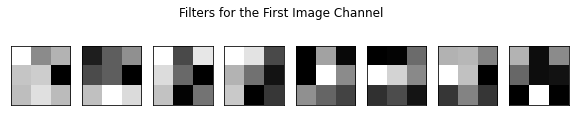

In [16]:
plot_filters(filters[0], grid_shape=(1, 8), figsize=(10, 2))
plt.suptitle('Filters for the First Image Channel');

The filters are generated from a uniformly random distribution. The light squares represent excitatory weights and the black square represent inhibitory weights. For example, the first filter detects a light to dark gradient from the southeast to northwest direction. 

# 5. Visualizing Feature Maps

It may be useful to visualize the output of our convolution to better understand what's being fed into our fully connected layers. We retrieve a sample frame stack from our dataset for this visualization:

In [17]:
sample_frame = np.moveaxis(grayscale(dataset_v0[50:53]), 0, -1)
sample_frame = np.expand_dims(sample_frame, axis=0)
sample_frame.shape

(1, 96, 96, 3)

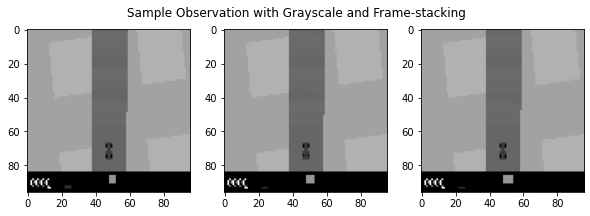

In [18]:
_, axes = plt.subplots(1, 3, figsize=(10, 3))
for i in range(sample_frame.shape[3]):
    axes[i].imshow(sample_frame[0, :, :, i], cmap='gray')
    
plt.suptitle('Sample Observation with Grayscale and Frame-stacking');

In [19]:
def plot_feature_maps(feature_maps, grid_shape, figsize):
    fig, axes = plt.subplots(*grid_shape, figsize=figsize)
    axes_iter = iter(axes.flatten())
    for i in range(feature_maps.shape[2]):
        ax = next(axes_iter)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(feature_maps[:, :, i], cmap='gray')    

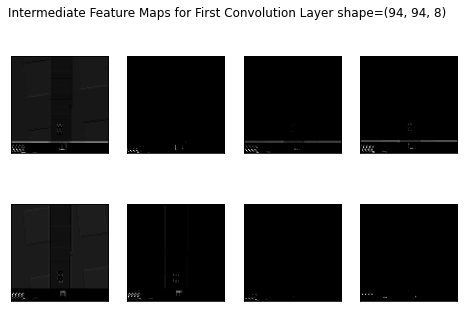

In [20]:
feature_maps = conv_models[0].predict(sample_frame)[0]
plot_feature_maps(feature_maps, grid_shape=(2, 4), figsize=(8, 5))
plt.suptitle(f'Intermediate Feature Maps for First Convolution Layer shape={feature_maps.shape}');

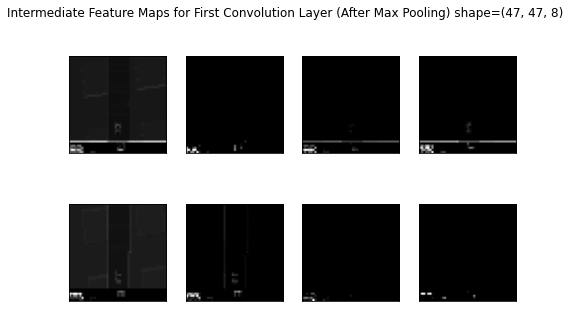

In [21]:
feature_maps = conv_models[1].predict(sample_frame)[0]
plot_feature_maps(feature_maps, grid_shape=(2, 4), figsize=(8, 5))
plt.suptitle(f'Intermediate Feature Maps for First Convolution Layer (After Max Pooling) shape={feature_maps.shape}');

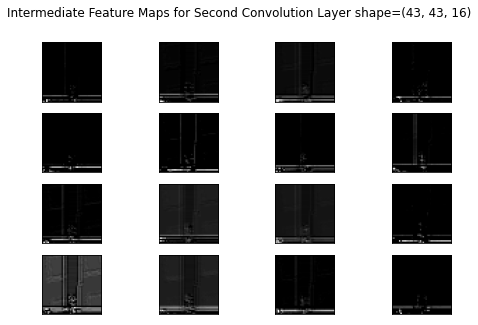

In [22]:
feature_maps = conv_models[2].predict(sample_frame)[0]
plot_feature_maps(feature_maps, grid_shape=(4, 4), figsize=(8, 5))
plt.suptitle(f'Intermediate Feature Maps for Second Convolution Layer shape={feature_maps.shape}');

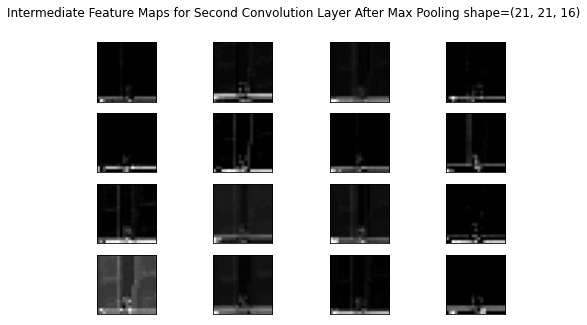

In [23]:
feature_maps = conv_models[3].predict(sample_frame)[0]
plot_feature_maps(feature_maps, grid_shape=(4, 4), figsize=(8, 5))
plt.suptitle(f'Intermediate Feature Maps for Second Convolution Layer After Max Pooling shape={feature_maps.shape}');

As we travel further into the network, we shed more and more details of the input image. We see that the metrics in the bottom panel become almost completely obfuscated, which may mean that this can be removed completely. Some output images are completely black, meaning that the matrix multiplication between the original frame and the filter resulted in mostly zeros.

# References

1. Mnih, V., Kavukcuoglu, K., Silver, D. et al. Human-level control through deep reinforcement learning. Nature 518, 529–533 (2015). https://doi.org/10.1038/nature14236